<p style="font-family: Arial; font-size:3.75em;color:purple; font-style:bold"><br>
'SiPM DST' Study</p><br>

# Prepares an analysis DST from FLEX data

In [1]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [78]:
# General importings
import os
import sys
import glob
import logging
import math
import numpy  as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

# Specific IC stuff
import invisible_cities.core.system_of_units  as units

from invisible_cities.io.mcinfo_io import load_mcconfiguration
from invisible_cities.io.mcinfo_io import load_mcparticles_df
from invisible_cities.io.mcinfo_io import load_mchits_df
from invisible_cities.io.mcinfo_io import load_mcsensor_positions
from invisible_cities.io.mcinfo_io import load_mcsensor_response_df
from invisible_cities.io.mcinfo_io import get_sensor_types
from invisible_cities.io.mcinfo_io import get_sensor_binning
from invisible_cities.io.mcinfo_io import get_event_numbers_in_file
from invisible_cities.core.core_functions import in_range


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

# Code

In [5]:
NN= -999999  # No Number, a trick to aovid nans in data structs


class NNN:

    def __getattr__(self, _):
        return NN


In [7]:
def get_evt_true_positions_df(mcParts):
    """Prepares a DF with the true position of the events using 
    the initial vertex of the first particle that is always primary
    
    """
    evt_truePos = mcParts.loc[pd.IndexSlice[:, 1], ['initial_x', 'initial_y', 'initial_z']]
    
    # Removing the 'particle_id' column
    evt_truePos = pd.DataFrame(evt_truePos.values,
                               index=evt_truePos.index.droplevel(1),
                               columns = ['true_x', 'true_y', 'true_z'])
    
    return evt_truePos

# DATA

In [8]:
VERBOSITY = True

# Input data

In [9]:
iPATH = "/Users/jj/Development/demoData/flex"

In [10]:
ifnames = glob.glob(f"{iPATH}/*.h5")

if VERBOSITY:
    print(f"{len(ifnames)} input file names ...\n")
    for ifname in ifnames:
        print(ifname)
        print(get_event_numbers_in_file(ifname))

2 input file names ...

/Users/jj/Development/demoData/flex/NEXT_FLEX.Kr83.ACTIVE.0.next.h5
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
/Users/jj/Development/demoData/flex/NEXT_FLEX.Kr83.ACTIVE.1.next.h5
[100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199]


In [11]:
# Verbosing main config parameters
if VERBOSITY:
    mcConfig = load_mcconfiguration(ifnames[0])
    mcConfig.set_index("param_key", inplace = True)
    main_params = ["/Geometry/NextFlex/e_lifetime", "/Geometry/NextFlex/el_gap_length",
                   "/Geometry/NextFlex/el_field_int", "/Geometry/NextFlex/tp_sipm_anode_dist",
                   "/Geometry/NextFlex/tp_teflon_thickness", "/Geometry/NextFlex/tp_teflon_hole_diam",
                   "/Geometry/NextFlex/tp_sipm_sizeX", "/Geometry/NextFlex/tp_sipm_pitchX",
                   "num_events", "TP_SiPM_binning", "F_SENSOR_L_binning", "F_SENSOR_R_binning"]
    print(mcConfig.loc[main_params])


                                                param_value
param_key                                                  
/Geometry/NextFlex/e_lifetime                     10000. ms
/Geometry/NextFlex/el_gap_length                    10.  mm
/Geometry/NextFlex/el_field_int             16. kilovolt/cm
/Geometry/NextFlex/tp_sipm_anode_dist              13.1  mm
/Geometry/NextFlex/tp_teflon_thickness               2.1 mm
/Geometry/NextFlex/tp_teflon_hole_diam               3.  mm
/Geometry/NextFlex/tp_sipm_sizeX                    1.0  mm
/Geometry/NextFlex/tp_sipm_pitchX                  15.55 mm
num_events                                              100
TP_SiPM_binning                                1.000000 mus
F_SENSOR_L_binning                             0.001000 mus
F_SENSOR_R_binning                             0.001000 mus


In [12]:
par = mcConfig.loc["/Geometry/NextFlex/tp_sipm_pitchX"]
par

param_value           15.55 mm
Name: /Geometry/NextFlex/tp_sipm_pitchX, dtype: object

## Extract pitch from params

In [13]:
pitch = float(par.param_value.split(' ')[-2])
pitch

15.55

## SiPMs are at indices < 10000 in dataframes 

In [14]:
sipm_index = 10000

## read SiPM map

In [15]:
sipm_map = pd.read_csv('sipm_map.csv')

In [16]:
sipm_map

,Unnamed: 0,sensor_id,sensor_name,x,y,xl,xr,yu,yd,id_xl,id_xr,id_yu,id_yd
0,0,3821,TP_SiPM,279.90,342.10,264.349994,295.449994,3.576500e+02,326.550006,3820,3822,3865,3775
1,1,2853,TP_SiPM,-108.85,77.75,-124.399998,-93.299998,9.330000e+01,62.200000,2852,2854,2914,2791
2,2,2732,TP_SiPM,-46.65,46.65,-62.200002,-31.100002,6.220000e+01,31.100002,2731,2733,2795,2669
3,3,2669,TP_SiPM,-46.65,31.10,-62.200002,-31.100002,4.665000e+01,15.550000,2668,2670,2732,2606
4,4,2479,TP_SiPM,-62.20,-15.55,-77.750001,-46.650001,-1.907349e-07,-31.100000,2478,2480,2542,2416
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3088,3088,1670,TP_SiPM,-419.85,-217.70,-435.400006,-404.300006,-2.021500e+02,-233.249997,1669,1671,1727,1614
3089,3089,1569,TP_SiPM,-279.90,-248.80,-295.449994,-264.349994,-2.332500e+02,-264.350003,1568,1570,1623,1516
3090,3090,3286,TP_SiPM,77.75,186.60,62.200000,93.300000,2.021500e+02,171.050006,3285,3287,3343,3228
3091,3091,1528,TP_SiPM,-93.30,-264.35,-108.850003,-77.750003,-2.488000e+02,-279.900006,1527,1529,1581,1476


## Sensors

In [17]:
get_sensor_binning(ifnames[0])

,bin_width
sns_name,
F_SENSOR_L,1.0
F_SENSOR_R,1.0
TP_SiPM,1000.0


In [18]:
sns_types = get_sensor_types(ifnames[0])
sns_types.head()

,sensor_id,sensor_name
0,101200,F_SENSOR_L
1,100109,F_SENSOR_L
2,100839,F_SENSOR_L
3,100819,F_SENSOR_L
4,100019,F_SENSOR_L


In [19]:
sns_positions = load_mcsensor_positions(ifnames[0])
sns_positions.head()

,sensor_id,sensor_name,x,y,z
0,101200,F_SENSOR_L,-486.079315,82.315834,-30.299999
1,100109,F_SENSOR_L,211.449921,445.351471,-30.299999
2,100839,F_SENSOR_L,-131.708267,-475.080963,-30.299999
3,100819,F_SENSOR_L,-92.674385,-484.211182,-30.299999
4,100019,F_SENSOR_L,38.055695,491.528992,-30.299999


## True position from MC particles

#### MC Particles

In [20]:
mcParts = load_mcparticles_df(ifnames[0])
print(mcParts.columns)
mcParts

Index(['particle_name', 'primary', 'mother_id', 'initial_x', 'initial_y',
       'initial_z', 'initial_t', 'final_x', 'final_y', 'final_z', 'final_t',
       'initial_volume', 'final_volume', 'initial_momentum_x',
       'initial_momentum_y', 'initial_momentum_z', 'final_momentum_x',
       'final_momentum_y', 'final_momentum_z', 'kin_energy', 'length',
       'creator_proc', 'final_proc'],
      dtype='object')


particle_name  primary  mother_id  initial_x  initial_y  \
event_id particle_id                                                           
0        3                      e-     True          0 -56.189575  45.298237   
         2                   gamma     True          0 -56.189575  45.298237   
         380669                 e-    False          2 -56.465294  45.457912   
         380668                 e-    False          2 -56.465294  45.457912   
         380667                 e-    False          2 -56.465294  45.457912   
...                            ...      ...        ...        ...        ...   
99       378070                 e-    False          2 -65.055962  -2.292888   
         378069                 e-    False          2 -65.055962  -2.292888   
         378068                 e-    False          2 -65.055962  -2.292888   
         378067                 e-    False          2 -65.055962  -2.292888   
         1                      e-     True          0 -63.312759  -1.815126   

                       initial_z  initial_t    final_x    final_y     final_z  \
event_id particle_id                                                            
0        3            699.266174   0.000000 -56.189659  45.280075  699.270569   
         2            699.266174   0.000000 -56.465294  45.457912  699.239929   
         380669       699.239929   0.001066 -56.465298  45.457909  699.239929   
         380668       699.239929   0.001066 -56.465298  45.457912  699.239868   
         380667       699.239929   0.001066 -56.465477  45.458103  699.239685   
...                          ...        ...        ...        ...         ...   
99       378070       215.728058   0.013221 -65.055962  -2.292828  215.728012   
         378069       215.728058   0.013221 -65.055893  -2.292759  215.728195   
         378068       215.728058   0.013221 -65.057037  -2.292559  215.729309   
         378067       215.728058   0.013221 -65.071854  -2.298036  215.733459   
         1            219.255478   0.000000 -63.310474  -1.763670  219.302505   

                      ...  initial_momentum_x initial_momentum_y  \
event_id particle_id  ...                                          
0        3            ...            0.084066          -0.019819   
         2            ...           -0.010865           0.006292   
         380669       ...           -0.002828          -0.003819   
         380668       ...           -0.004023           0.001364   
         380667       ...           -0.012960           0.013636   
...                   ...                 ...                ...   
99       378070       ...           -0.000158           0.005609   
         378069       ...            0.006837           0.013215   
         378068       ...            0.062572          -0.003227   
         378067       ...           -0.061036          -0.007538   
         1            ...           -0.012102           0.116082   

                     initial_momentum_z  final_momentum_x  final_momentum_y  \
event_id particle_id                                                          
0        3                    -0.047235              -0.0               0.0   
         2                    -0.001036              -0.0               0.0   
         380669               -0.003370              -0.0              -0.0   
         380668               -0.004243              -0.0              -0.0   
         380667               -0.014555              -0.0               0.0   
...                                 ...               ...               ...   
99       378070               -0.004196               0.0              -0.0   
         378069                0.014162               0.0               0.0   
         378068                0.015918              -0.0              -0.0   
         378067                0.063829              -0.0               0.0   
         1                     0.083336              -0.0               0.0   

             

In [21]:
evt0 = mcParts[mcParts.primary].loc[0]

In [22]:
evt0

,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
particle_id,,,,,,,,,,,,,,,,,,,,,
3,e-,True,0,-56.189575,45.298237,699.266174,0.0,-56.189659,45.280075,699.270569,...,0.084066,-0.019819,-0.047235,-0.0,0.0,-0.0,0.009396,0.073767,none,Scintillation
2,gamma,True,0,-56.189575,45.298237,699.266174,0.0,-56.465294,45.457912,699.239929,...,-0.010865,0.006292,-0.001036,-0.0,0.0,-0.0,0.012598,0.319702,none,phot
1,e-,True,0,-56.189575,45.298237,699.266174,0.0,-56.165462,45.262466,699.318176,...,-0.137422,-0.017296,0.034315,-0.0,0.0,-0.0,0.019549,0.191136,none,Scintillation


## Krypton energy in keV

In [24]:
Ekr = np.sum(evt0.kin_energy)*1e+3
print(f'Krypton energy in keV = {Ekr}')

Krypton energy in keV = 41.543297469615936


## S1 time

In [47]:
s1_time = 1 * units.mus

#### MC Hits

In [25]:
mcHits = load_mchits_df(ifnames[0])
print(mcHits.columns)
mcHits.head()

Index(['x', 'y', 'z', 'time', 'energy', 'label'], dtype='object')


x          y           z      time  \
event_id particle_id hit_id                                               
0        3           0      -56.185802  45.296860  699.264343  0.000078   
                     1      -56.184433  45.293285  699.263428  0.000148   
                     2      -56.183174  45.289669  699.262085  0.000221   
                     3      -56.180603  45.288792  699.261841  0.000271   
                     4      -56.180313  45.288155  699.264465  0.000323   

                               energy   label  
event_id particle_id hit_id                    
0        3           0       0.000186  ACTIVE  
                     1       0.000096  ACTIVE  
                     2       0.000547  ACTIVE  
                     3       0.001003  ACTIVE  
                     4       0.000052  ACTIVE

In [26]:
true_positions = get_evt_true_positions_df(mcParts)

In [27]:
true_positions

,true_x,true_y,true_z
event_id,,,
0,-56.189575,45.298237,699.266174
1,-204.040588,82.765907,1015.823975
2,-106.802177,361.837128,72.865242
3,-286.395020,30.258028,601.792908
4,-211.909500,72.846420,256.701111
...,...,...,...
95,-255.406860,-186.872360,828.706848
96,464.921906,127.380112,96.327408
97,26.906584,373.798248,688.268555


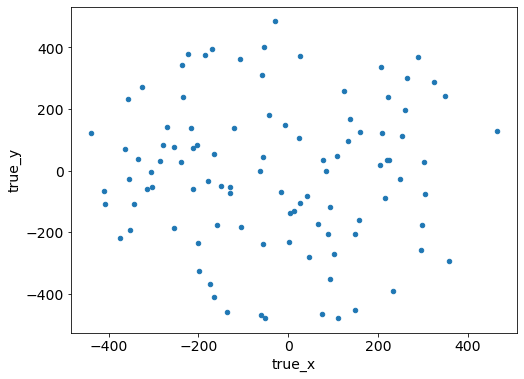

In [28]:
true_positions.plot(kind='scatter', x='true_x', y='true_y')

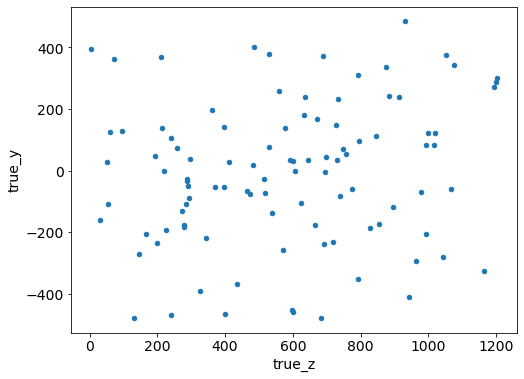

In [29]:
true_positions.plot(kind='scatter', x='true_z', y='true_y')

## SENSORS RESPONSE

In [30]:
sns_response = load_mcsensor_response_df(ifnames[0])
sns_response

charge      time
event_id sensor_id                  
0        101200          1  698166.0
         101200          1  698239.0
         101200          1  698512.0
         101200          1  698939.0
         101200          1  699360.0
...                    ...       ...
56       3287            1  599000.0
61       3287            1  671000.0
         3287            3  672000.0
         3287            1  673000.0
79       3287            1   59000.0

[5502635 rows x 2 columns]

In [31]:
sipm_response = sns_response[sns_response.index \
                               .get_level_values("sensor_id") < sipm_index]

In [32]:
sipm_response

charge      time
event_id sensor_id                  
0        3821            1  699000.0
2        3821            1   74000.0
19       3821            1  779000.0
25       3821            1  487000.0
27       3821            2  150000.0
...                    ...       ...
56       3287            1  599000.0
61       3287            1  671000.0
         3287            3  672000.0
         3287            1  673000.0
79       3287            1   59000.0

[93470 rows x 2 columns]

In [33]:
fibers_response = sns_response[sns_response.index.get_level_values("sensor_id") >= sipm_index]

In [34]:
fibers_response

charge      time
event_id sensor_id                  
0        101200          1  698166.0
         101200          1  698239.0
         101200          1  698512.0
         101200          1  698939.0
         101200          1  699360.0
...                    ...       ...
99       201117          1  222542.0
         201117          1  222612.0
         201117          1  222930.0
         201117          1  223517.0
         201117          1  224182.0

[5409165 rows x 2 columns]

In [35]:
grouped_multiple = sipm_response.groupby(['event_id', 'sensor_id']).agg({'charge': ['sum']})
grouped_multiple.columns = ['tot_charge']
sipmdf = grouped_multiple.reset_index()
sipmdf


,event_id,sensor_id,tot_charge
0,0,1010,1
1,0,1016,1
2,0,1019,2
3,0,1024,1
4,0,1027,2
...,...,...,...
62511,99,4083,2
62512,99,4088,1
62513,99,4089,2
62514,99,4090,1


In [42]:
sipm0 = sipmdf[sipmdf.event_id==0]
sipm0

,event_id,sensor_id,tot_charge
0,0,1010,1
1,0,1016,1
2,0,1019,2
3,0,1024,1
4,0,1027,2
...,...,...,...
683,0,4086,1
684,0,4087,1
685,0,4088,1
686,0,4090,1


In [44]:
sipm0.tot_charge.max()

74

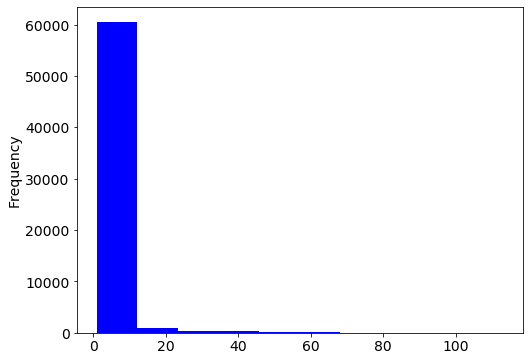

In [45]:
sipmdf['tot_charge'].plot(kind='hist', color='blue')

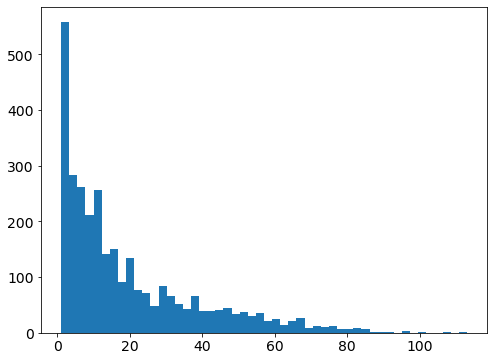

In [46]:
_, _, _ = plt.hist(sipmdf.groupby('sensor_id').tot_charge.max(), bins=50)

In [48]:
true_positions['S1e'] = fibers_response[fibers_response.time < s1_time].groupby('event_id').charge.sum()
true_positions['S2e'] = fibers_response[fibers_response.time > s1_time].groupby('event_id').charge.sum()

In [49]:
true_positions

,true_x,true_y,true_z,S1e,S2e
event_id,,,,,
0,-56.189575,45.298237,699.266174,104,51393
1,-204.040588,82.765907,1015.823975,109,52672
2,-106.802177,361.837128,72.865242,86,53380
3,-286.395020,30.258028,601.792908,111,52792
4,-211.909500,72.846420,256.701111,94,51836
...,...,...,...,...,...
95,-255.406860,-186.872360,828.706848,90,52152
96,464.921906,127.380112,96.327408,92,67676
97,26.906584,373.798248,688.268555,108,54002


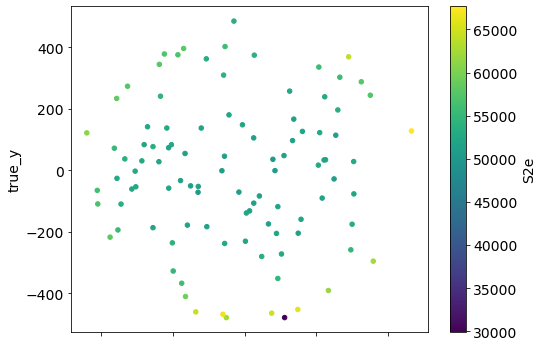

In [50]:
true_positions.plot(kind='scatter', x='true_x', y='true_y', c='S2e', cmap='viridis')

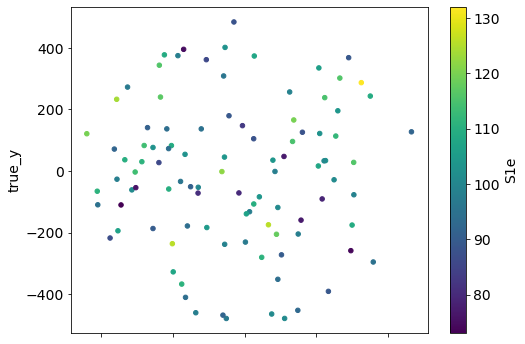

In [51]:
true_positions.plot(kind='scatter', x='true_x', y='true_y', c='S1e', cmap='viridis')

In [52]:
v = [1,2,3]
np.linalg.norm(v) 

3.7416573867739413

In [54]:
np.sqrt(np.dot(v,v))

3.7416573867739413

In [56]:
def kr_dst(ifnames, sipm_map, key_sensor_fibres = 100000, s1_time = 1.*units.mus, verbose=False, ic=100):
    """Prepares an analysis dst for Krypton, including:
    
    1. True positions from the MC
    2. Computed positions from Barycenter (around SiPM with max charge) -- after integrating all time bins
    3. S1e from fibers --- MC response
    2. S2e from MC     --- MC response
    
    """
    
    def sipm_time_integral():
        grouped_multiple = sipm_response.groupby(['event_id', 'sensor_id']).agg({'charge': ['sum']})
        grouped_multiple.columns = ['tot_charge']
        return grouped_multiple.reset_index()
            
    def get_q(ix):
        if ix != NN:
            q = evt[evt.sensor_id==ix].tot_charge.values[0]
        else:
            q = 0        
        return q
    
    def get_pos(vz, vq):
        return np.dot(vz, vq) / np.sum(vq) 
    
    
    mcParts         = pd.DataFrame()
    fibers_response = pd.DataFrame()
    sipm_response   = pd.DataFrame()
    for ifname in ifnames:
        mcParts         = mcParts.append(load_mcparticles_df(ifname))
    
        sns_response    = load_mcsensor_response_df(ifname)    
        fibers_response = fibers_response.append(sns_response[sns_response.index
                                                          .get_level_values("sensor_id") >= key_sensor_fibres])
        sipm_response   = sipm_response.append(sns_response[sns_response.index
                                                          .get_level_values("sensor_id") < key_sensor_fibres])
    sipmdf = sipm_time_integral()
    
    krdf = get_evt_true_positions_df(mcParts)
    krdf['S1e'] = fibers_response[fibers_response.time < s1_time].groupby('event_id').charge.sum()
    krdf['S2e'] = fibers_response[fibers_response.time > s1_time].groupby('event_id').charge.sum()
    
    
    xMax = []
    xPos = []
    yMax = []
    yPos = []
    for i in krdf.index:
        if verbose and i%ic == 0:
            print(i)
            
        evt          = sipmdf[sipmdf.event_id==i]
        qmax         = evt.tot_charge.max()
        iqmax        = evt[evt.tot_charge==qmax].sensor_id.values[0]

        qmaxdf       = sipm_map[sipm_map.sensor_id==iqmax]
        xqmax, yqmax =  qmaxdf.x.values[0], qmaxdf.y.values[0]
        xl, xr       =  qmaxdf.xl.values[0], qmaxdf.xr.values[0]
        yu, yd       =  qmaxdf.yu.values[0], qmaxdf.yd.values[0]
        
        ql = get_q(qmaxdf.id_xl.values[0])
        qr = get_q(qmaxdf.id_xr.values[0])
        qu = get_q(qmaxdf.id_yu.values[0])
        qd = get_q(qmaxdf.id_yd.values[0])
        
        xp = get_pos(np.array([xqmax, xl, xr]), np.array([qmax, ql, qr]))
        yp = get_pos(np.array([yqmax, yu, yd]), np.array([qmax, qu, qd]))
 
        xMax.append(xqmax)
        xPos.append(xp)
        yMax.append(yqmax)
        yPos.append(yp)

    krdf['xmax'] = xMax
    krdf['ymax'] = yMax
    krdf['xpos'] = xPos
    krdf['ypos'] = yPos

    
    return krdf

In [60]:
krdst = kr_dst(ifnames, sipm_map, verbose=True, ic=10)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


In [61]:
krdst

,true_x,true_y,true_z,S1e,S2e,xmax,ymax,xpos,ypos
event_id,,,,,,,,,
0,-56.189575,45.298237,699.266174,104,51393,-62.20,46.65,-59.487791,45.345807
1,-204.040588,82.765907,1015.823975,109,52672,-202.15,77.75,-202.911186,80.142308
2,-106.802177,361.837128,72.865242,86,53380,-108.85,357.65,-107.739285,359.490233
3,-286.395020,30.258028,601.792908,111,52792,-279.90,31.10,-282.940499,30.074725
4,-211.909500,72.846420,256.701111,94,51836,-202.15,77.75,-205.451114,76.414417
...,...,...,...,...,...,...,...,...,...
195,-328.773773,-64.463905,540.061523,91,52999,-326.55,-62.20,-328.598497,-64.558708
196,431.723480,-211.044281,1140.764893,96,57871,435.40,-202.15,429.877568,-204.661177
197,226.877975,31.063253,352.058563,103,51846,233.25,31.10,229.784036,30.601070


In [74]:
def sigma_max_true(krdst, true='true_x', var='xmax', bins=10, alpha=0.6, color='g'):
    dx = (krdst[true] - krdst[var]).values
    mu, std = norm.fit(dx)
    plt.hist(dx, bins=bins, density=True, alpha=alpha, color=color)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
    plt.title(title)
    plt.show()
    

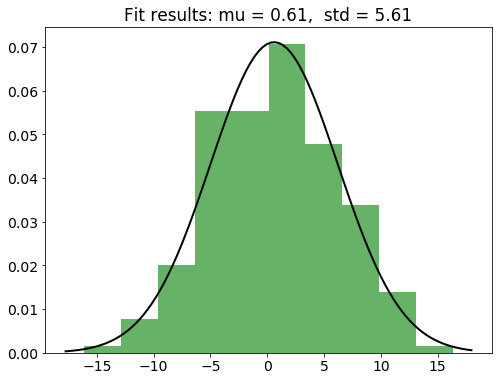

In [75]:
sigma_max_true(krdst, true='true_x', var='xmax', bins=10, alpha=0.6, color='g')

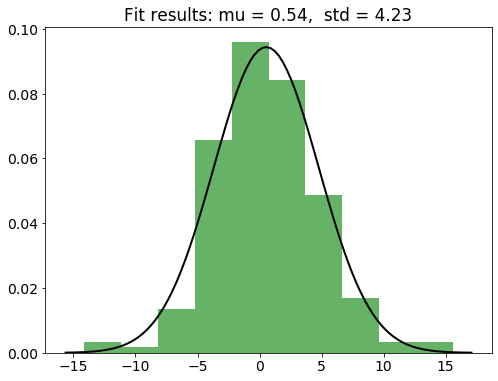

In [76]:
sigma_max_true(krdst, true='true_x', var='xpos', bins=10, alpha=0.6, color='g')

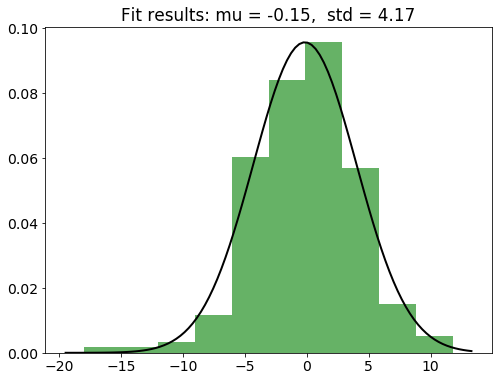

In [77]:
sigma_max_true(krdst, true='true_y', var='ypos', bins=10, alpha=0.6, color='g')

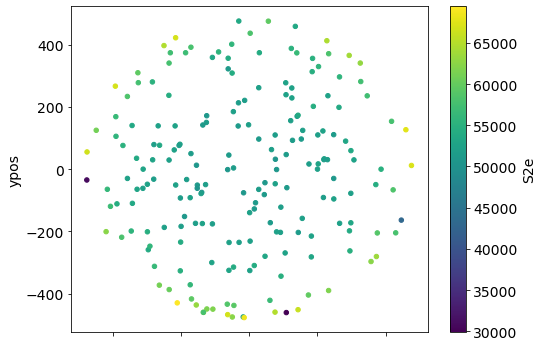

In [80]:
krdst.plot(kind='scatter', x='xpos', y='ypos', c='S2e', cmap='viridis')

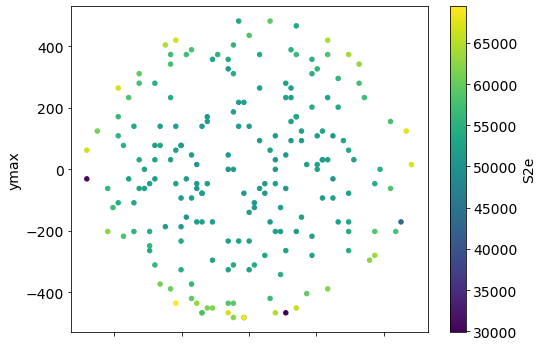

In [81]:
krdst.plot(kind='scatter', x='xmax', y='ymax', c='S2e', cmap='viridis')

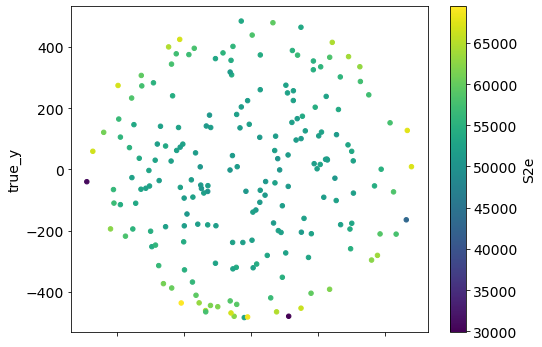

In [82]:
krdst.plot(kind='scatter', x='true_x', y='true_y', c='S2e', cmap='viridis')

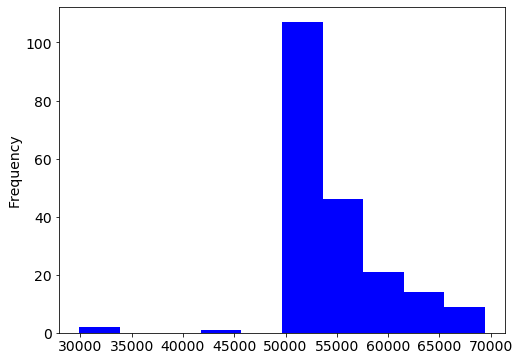

In [84]:
krdst['S2e'].plot(kind='hist', color='blue')

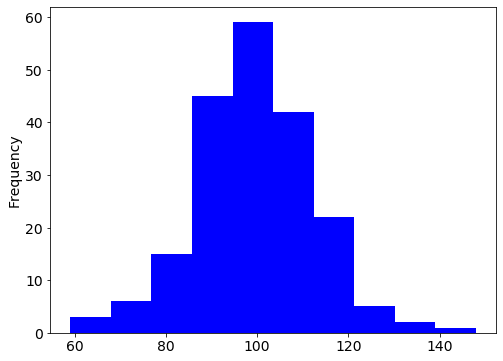

In [85]:
krdst['S1e'].plot(kind='hist', color='blue')

In [86]:
krdst.to_csv('krdst.csv')